<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202402/blob/main/Lecture10/Notebook_Causal_Trees.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Aplications


-   To illustrate how it works let me use this experiment from the General Social Survey (GSS)

-   GSS conducts surveys regular surveys on Americans think feel about different issues

-   For decades, scholars studying Americans' support for social welfare spending have noted the special disdain that americans harbor for programs labeled "welfare"

-   This phenomenon became the subject of sustained experimental inquiry in the mid-1980s, when the GSS included a question-wording experiment in its national survey of adults.


-   Respondents in each survey were randomly assigned to one of two questions about public spending.

-   *"too much" money is spent on assistance to the Poor (treatment) or Welfare (control)*

-   Various explanations put forward: stereotypes associated with welfare recipients and poor people, particularly racial stereotypes, and to political orientations such as individualism and conservatism .


## Loading packages

Let's load the packages

In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [2]:
set.seed(201911) 

require("pacman")
p_load("tidyverse",# Data wrangling       
        "fBasics",     # Summary statistics 
        "corrplot",    # Correlations 
        "psych",       # Correlation p-values 
        "hdm",         # High-Dimensional Metrics
        "rpart",       # Classification and regression trees
        "rpart.plot",  # Plotting trees 
        "car",         # linear hypothesis testing for causal tree
        "aod")         # hypothesis testing 


Loading required package: pacman



**Non-CRAN packages:** The packages below have not yet been uploaded to CRAN or any other major package repository, but we can grab them from their authors' github webpages. If you don't have these packages installed already, uncomment the relevant line below to install it.

In [3]:
# For causal trees (Athey and Imbens, 2016)  version 0.0
#library(devtools)    # Install packages from github 
#install_github("susanathey/causalTree")
require("causalTree")

Loading required package: causalTree

Loading required package: data.table

Warning message:
“package ‘data.table’ was built under R version 4.4.1”

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Loading the data

We will be working with the `welfare` dataset, from "Modeling Heterogeneous Treatment Effects in Survey Experiments with Baysian Additive Regression Trees" (Green and Kern, 2012) ).

Next, we load in the raw data and perform some data cleaning.

In [4]:
# R script for reading data from github repository, set path to where you have the tutorial files saved.
df_experiment<-readRDS(url("https://github.com/ignaciomsarmiento/datasets/raw/main/welfare.rds"))


In [5]:
head(df_experiment)

,ID,Y,W,hrs1,partyid,income,rincome,wrkstat,wrkslf,age,⋯,parborn,maeduc,degree,sex,born,hompop,babies,preteen,teens,adults
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,40,4,12,11,1,2,29,⋯,0,16,3,2,1,2,0,0,0,2
2,2,0,1,35,1,12,12,1,2,48,⋯,0,20,3,2,1,1,0,0,0,1
3,3,1,1,30,2,12,9,1,2,27,⋯,0,8,1,2,1,2,0,0,0,2
4,4,1,0,40,2,12,12,1,2,27,⋯,8,4,1,2,1,2,0,1,0,1
5,5,1,0,35,1,11,11,1,2,24,⋯,0,12,2,1,1,1,0,0,0,1
6,6,0,1,38,2,12,12,1,2,24,⋯,8,9,0,1,1,4,1,1,0,2


## Cleaning the data

Let's do some minimal housekeeping. First, we will drop the columns that aren't outcomes, treatments or (pre-treatment) covariates, since we won't be using those.


In [6]:
covariate_names<- c("hrs1", "partyid", "income", "rincome", "wrkstat", "wrkslf", "age", "polviews", "educ", "earnrs", "race", "marital", "sibs", "childs", "occ80", "prestg80", "indus80", "res16", "reg16", "mobile16", "family16", "parborn", "maeduc", "degree", "sex", "born", "hompop", "babies", "preteen", "teens", "adults")

In [7]:
# Combine all names
all_variables_names <- c("Y", "W", covariate_names)
df <- df_experiment %>% select(all_of(all_variables_names))

Next, let's drop any row that has missing values in them.

In [8]:
# Drop rows containing missing values
df <- df %>% drop_na()

Some of the methods below don't accept `factor` variables, so let's change their type to `numeric` here. 

In [9]:
# Converting all columns to numerical and add row id
df <- data.frame(lapply(df, function(x) as.numeric(as.character(x))))

df <- df %>% mutate_if(is.character,as.numeric)
df <- df %>% rowid_to_column( "ID")

head(df)

,ID,Y,W,hrs1,partyid,income,rincome,wrkstat,wrkslf,age,⋯,parborn,maeduc,degree,sex,born,hompop,babies,preteen,teens,adults
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,40,4,12,11,1,2,29,⋯,0,16,3,2,1,2,0,0,0,2
2,2,0,1,35,1,12,12,1,2,48,⋯,0,20,3,2,1,1,0,0,0,1
3,3,1,1,30,2,12,9,1,2,27,⋯,0,8,1,2,1,2,0,0,0,2
4,4,1,0,40,2,12,12,1,2,27,⋯,8,4,1,2,1,2,0,1,0,1
5,5,1,0,35,1,11,11,1,2,24,⋯,0,12,2,1,1,1,0,0,0,1
6,6,0,1,38,2,12,12,1,2,24,⋯,8,9,0,1,1,4,1,1,0,2


---

## Descriptive statistics

It's often useful to begin data analysis by simply looking at simple summary statistics. We use the function `basicStats` from the package `fBasics` to calculate them.

In [10]:
# Make a data.frame containing summary statistics of interest
summ_stats <- fBasics::basicStats(df)
summ_stats <- as.data.frame(t(summ_stats))
# Rename some of the columns for convenience
summ_stats <- summ_stats %>% select("Mean", "Stdev", "Minimum", "1. Quartile", "Median",  "3. Quartile", "Maximum")
summ_stats <- summ_stats %>% rename('Lower quartile'= '1. Quartile', 'Upper quartile' ='3. Quartile')

In [11]:
summ_stats

,Mean,Stdev,Minimum,Lower quartile,Median,Upper quartile,Maximum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ID,6599.500000,3810.078761,1,3300.25,6599.5,9898.75,13198
Y,0.290423,0.453975,0,0.00,0.0,1.00,1
W,0.514245,0.499816,0,0.00,1.0,1.00,1
hrs1,42.258827,14.006607,0,38.00,40.0,50.00,89
partyid,2.947719,2.033141,0,1.00,3.0,5.00,7
income,11.292469,1.646972,1,11.00,12.0,12.00,12
rincome,10.204501,2.750699,1,9.00,12.0,12.00,12
wrkstat,1.156312,0.363164,1,1.00,1.0,1.00,2
wrkslf,1.875511,0.330151,1,2.00,2.0,2.00,2


Presenting pairwise correlations is easy with the `corrplot` function from the `corrplot` package. On the table below, if the (unadjusted) p-value for a pair of variables is less than 0.05, its square is not colored.

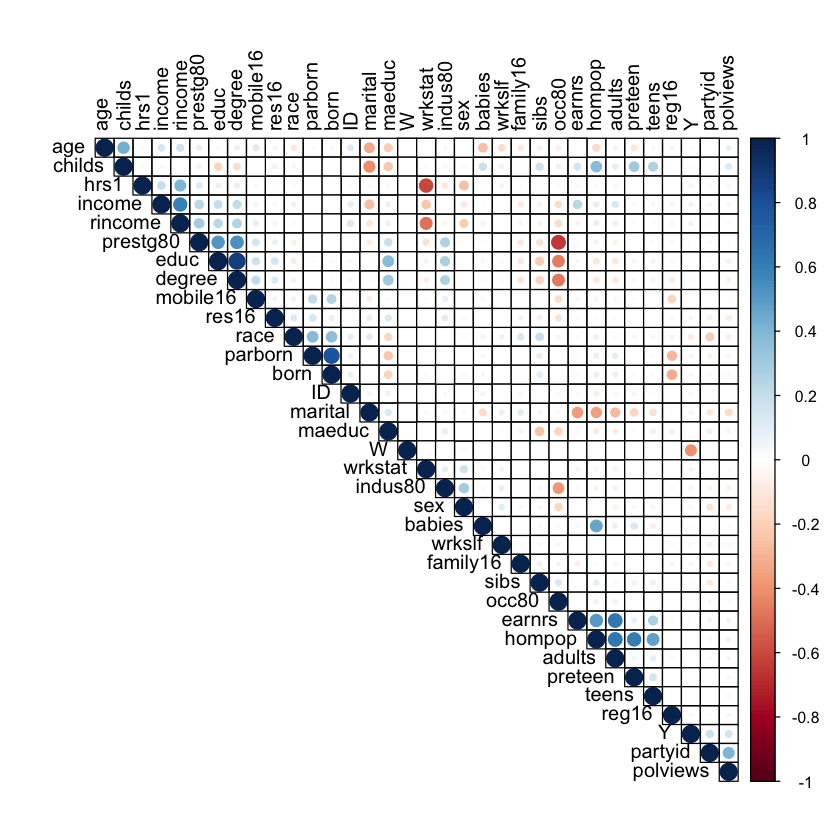

In [12]:
# Note: if the plot looks too cramped, try increasing fig.width and fig.height in the line above
pairwise_pvalues <- psych::corr.test(df, df)$p
corrplot(cor(df),
        type="upper",
        tl.col="black",
        order="hclust",
        tl.cex=1,
        addgrid.col = "black",
        p.mat=pairwise_pvalues,
        sig.level=0.05,
        number.font=10,
        insig="blank")

# PART I: ATE y CATE

 *"too much" money is spent on assistance to the Poor (treatment) or Welfare (control)*

In [13]:
tapply(df$Y,df$W,mean)

0         1 
0.4805803 0.1108001

- 48% agree that too much money is spent on Welfare
- 11% agree that too much money is spent on assistance to the Poor

In [14]:
difference_in_means <- function(dataset) {
  # Filter treatment / control observations, pulls outcome variable as a vector
  y1 <- dataset %>% dplyr::filter(W == 1) %>% dplyr::pull(Y) # Outcome in treatment grp
  y0 <- dataset %>% dplyr::filter(W == 0) %>% dplyr::pull(Y) # Outcome in control group
  
  n1 <- sum(df[,"W"])     # Number of obs in treatment
  n0 <- sum(1 - df[,"W"]) # Number of obs in control
  
  # Difference in means is ATE
  tauhat <- mean(y1) - mean(y0)
  
  # 95% Confidence intervals
  se_hat <- sqrt( var(y0)/(n0-1) + var(y1)/(n1-1) )
  lower_ci <- tauhat - 1.96 * se_hat
  upper_ci <- tauhat + 1.96 * se_hat
  
  return(c(ATE = tauhat, lower_ci = lower_ci, upper_ci = upper_ci))
}

tauhat_rct <- difference_in_means(df)
tauhat_rct

ATE   lower_ci   upper_ci 
-0.3697802 -0.3841123 -0.3554481

In [15]:
ols_ate <- lm(Y~W, data=df)

In [16]:
fmla <- as.formula(paste("Y ~ W +", paste(covariate_names, collapse= "+")))
ols_cate <- lm(fmla, data=df)
stargazer::stargazer(ols_ate,ols_cate,type="text")


                                      Dependent variable:                   
                    --------------------------------------------------------
                                               Y                            
                                (1)                          (2)            
----------------------------------------------------------------------------
W                            -0.370***                    -0.368***         
                              (0.007)                      (0.007)          
                                                                            
hrs1                                                      0.001***          
                                                          (0.0003)          
                                                                            
partyid                                                   0.027***          
                                                           (0.002)         

# Part II: HTE, Causal Trees



-   Some authors consider the interaction between the treatment and attributions, e.g.

    -   Federico (2004) examines a complicated three-way interaction between the treatment, education, and racial perceptions.

    -   Jacoby (2000) suggests that party and ideology may make some respondents especially receptive to the more specific program (should strong and weak Democrats be treated as separate subgroups or should they be combined?)
        
Let's see how to analyze the data set selected above for heterogeneous treatment effects.        



-   We need to proceed in steps

-   **Step 1**: Split the dataset. Why? $\rightarrow$ Athey and Imbens
    innovation $\rightarrow$ **Honesty**
        
-   **Step 2**: Fit the tree
-   **Step 3**: Crossvalidate
-   **Step 4**: Predict point estimates (on estimation sample)
-   **Step 5**: Compute standard errors
-   **Step 6**: Predict point estimates (on test set)        
        


Before we start let’s separate a portion of our dataset as a test set. Later we will use this subset to evaluate the performance.

In [17]:
train_fraction <- 0.80  # Use train_fraction % of the dataset to train our models

df_train <- sample_frac(df, replace=F, size=train_fraction)
df_test <- anti_join(df,df_train, by = "ID")#need to check on larger datasets

#### Step 1: Split the dataset

As we just explained, honesty requires us to separate different subsets of our training data for model selection and prediction.

+ `df_split`: the *splitting sample*, used to build the tree
+ `df_est`: the *estimation sample*, used to compute the average treatment effect in each leaf

In [18]:
# Diving the data 40%-40%-20% into splitting, estimation and validation samples
split_size <- floor(nrow(df_train) * 0.5)
df_split <- sample_n(df_train, replace=FALSE, size=split_size)

# Make the splits
df_est <- anti_join(df_train,df_split, by ="ID")

#### Step 2: Fit the tree

Begin by defining a formula containing only the outcome and the covariates.

In [19]:
fmla_ct <- paste("factor(Y) ~", paste(covariate_names, collapse = " + "))

print('This is our regression model')
print( fmla_ct)

[1] "This is our regression model"
[1] "factor(Y) ~ hrs1 + partyid + income + rincome + wrkstat + wrkslf + age + polviews + educ + earnrs + race + marital + sibs + childs + occ80 + prestg80 + indus80 + res16 + reg16 + mobile16 + family16 + parborn + maeduc + degree + sex + born + hompop + babies + preteen + teens + adults"


Next, we use the `honest.causalTree` function from the `causalTree` package. To ensure that honesty is enabled, the parameters for splitting and cross-validation below should not be changed. However, if your tree is not splitting at all, try decreasing the parameter `minsize` that controls the minimum size of each leaf.

For more details on other parameters, please take a look at this extended [documentation](https://github.com/susanathey/causalTree/blob/master/briefintro.pdf) for the `causalTree` paper.


In [20]:
ct_unpruned <- honest.causalTree(
  formula = fmla_ct,            # Define the model
  data = df_split,              # Subset used to create tree structure
  est_data = df_est,            # Which data set to use to estimate effects

  treatment = df_split$W,       # Splitting sample treatment variable
  est_treatment = df_est$W,     # Estimation sample treatment variable

  split.Rule = "CT",            # Define the splitting option
  cv.option = "TOT",            # Cross validation options

  split.Honest = TRUE,          # Use honesty when splitting
  cv.Honest = TRUE,             # Use honesty when performing cross-validation

  minsize = 30,                 # Min. number of treatment and control cases in each leaf
  HonestSampleSize = nrow(df_est)) # Num obs used in estimation after building the tree

[1] 2
[1] "CT"


The resulting object will be `rpart` objects, so `rpart` methods for cross-validation and plotting can be used.

#### Step 3: Cross-validate

We must prune the tree by cross-validation to avoid overfitting. The honest cross-validation method selected above (and recommended) penalizes an estimate of the variance in the treatment effects estimates across leaves, and this estimate is computed using the estimation sample. The `cv.option` selected above ($TOT$) uses an unbiased estimate of the test mean-squared error.


In [21]:
# Table of cross-validated values by tuning parameter.
ct_cptable <- as.data.frame(ct_unpruned$cptable)

# Obtain optimal complexity parameter to prune tree.
selected_cp <- which.min(ct_cptable$xerror)
optim_cp_ct <- ct_cptable[selected_cp, "CP"]

# Prune the tree at optimal complexity parameter.
ct_pruned <- prune(tree = ct_unpruned, cp = optim_cp_ct)

#### Step 4: Predict point estimates (on estimation sample)

To predict the treatment effect on the estimation sample, use the function `predict` as below.

In [22]:
tauhat_ct_est <- predict(ct_pruned, newdata = df_est)
head(tauhat_ct_est)

1          2          3          4          5          6 
-0.3843850 -0.4043439 -0.3843850 -0.4043439 -0.4043439 -0.3843850

#### Step 5: Compute standard errors

The `causalTree` package does not compute standard errors by default, but we can compute them using the following trick. First, define $L_{\ell}$ to indicate assignment to leaf $\ell$ and consider the following linear model.

\begin{align}
Y = \sum_{\ell} L_{\ell}\alpha_{\ell} + W \cdot L_{\ell} \beta_{\ell}
\end{align}

In [23]:
# Create a factor column 'leaf' indicating leaf assignment
num_leaves <- length(unique(tauhat_ct_est))  #There are as many leaves as there are predictions

df_est$leaf <- factor(tauhat_ct_est, labels = seq(num_leaves))

# Run the regression
ols_ct <- lm(as.formula("Y ~ 0 + leaf + W:leaf"), data= df_est) 
print(as.formula("Y ~ 0 + leaf + W:leaf"))

Y ~ 0 + leaf + W:leaf


The interaction coefficients in this regression recover the average treatment effects in each leaf, since

\begin{align}
  E[Y|W=1, L=1] - E[Y|W=0, L=1] = (\alpha_{1} + \beta_{1}) - (\alpha_{1}) = \beta_{1}
\end{align}

Therefore, the standard error around the coefficients is also the standard error around the treatment effects. In the next subsection, we will also use these statistics to test hypothesis about leaf estimates.

In [24]:
ols_ct_summary <- summary(ols_ct)
te_summary <- coef(ols_ct_summary)[(num_leaves+1):(2*num_leaves), c("Estimate", "Std. Error")]
te_summary

,Estimate,Std. Error
leaf1:W,-0.4043439,0.01592351
leaf2:W,-0.3843850,0.02141524
leaf3:W,-0.3315372,0.06334838
leaf4:W,-0.3167446,0.03094030
leaf5:W,-0.2124060,0.04969681


#### Step 6: Predict point estimates (on test set)

To predict the treatment effect on a new, entirely unseen data, use the function `predict` as below.

In [25]:
tauhat_ct_test <- predict(ct_pruned, newdata = df_test)

### Assessing heterogeneity

A natural place to begin is by ploting the (pruned) tree. We can use the `rpart.plot` function from the `rpart.plot` package.

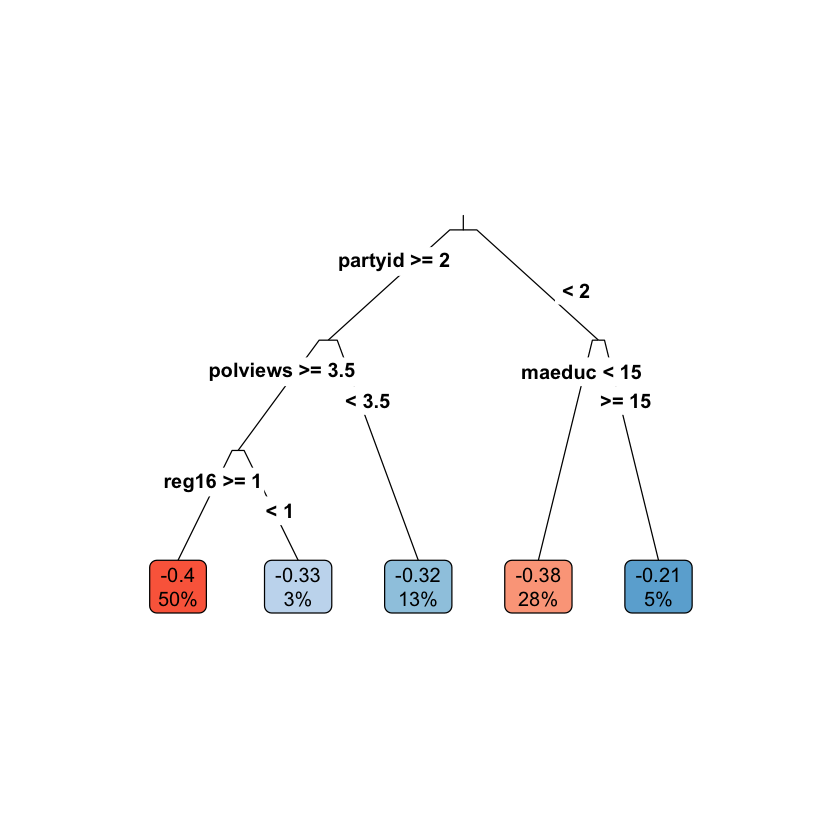

In [28]:
rpart.plot(
  x = ct_pruned,        # Pruned tree
  type = 3,             # Draw separate split labels for the left and right directions
  fallen = TRUE,        # Position the leaf nodes at the bottom of the graph
  leaf.round = 1,       # Rounding of the corners of the leaf node boxes
  extra = 100,          # Display the percentage of observations in the node
  branch = 0.1,          # Shape of the branch lines
  box.palette = "RdBu") # Palette for coloring the node

#### Treatment effect heterogeneity

We may want to test the treatment effect is different across leaves. That is, to test the null hypothesis that

$$
 E[Y|W=1, L=1] - E[Y|W=0, L=1] =  E[Y|W=1, L=\ell] - E[Y|W=0, L=\ell] \quad \text{for all } \ell > 1
$$

Following the linear model setup described in Step 5 in the previous subsection, we can use the function `linearHypothesis` from the `car` package to test this hypothesis.

In [27]:
# Null hypothesis: all leaf values are the same
hypothesis <- paste0("leaf1:W = leaf", seq(2, num_leaves), ":W")
ftest <- linearHypothesis(ols_ct, hypothesis, test="F")
ftest

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5273,890.6533,NA,NA,NA,NA
2,5269,887.5693,4,3.08395,4.576919,0.001088182
